In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# -----CONSTANTS------
MU_REGOLITH = 0.41 # μ from Holsapple paper's value for lunar regolith
RHO_IMP_G_CM3 = 2.7 # impactor density
RHO_IMP_KG_M3 = RHO_IMP_G_CM3 * 1000.0  # converted to kg/m^3
MEAN_IMPACT_VEL_KM_S = 17.0 #From Yue et al. (2013)
MEAN_IMPACT_VEL_M_S = MEAN_IMPACT_VEL_KM_S * 1000.0
N_MONTE_CARLO = 1000000 # monte carlo run number
VEL_EXPONENT = 0.44
CRATER_TO_PROJECTILE_RATIO = 10.0


# ------ FUNCTIONS ----------
def load_crater_catalog(csv_path: str) -> pd.DataFrame:
    """
    Get the whole database's worth of crater diameters
    """
    df = pd.read_csv(csv_path)
    df = df.copy()
    df["D_final_m"] = df["DIAM_CIRC_IMG"] * 1000.0
    return df

def get_simple_craters(df: pd.DataFrame, simple_limit_km: float = 10.6) -> pd.DataFrame:
    """
    Filter the crater database down to simple craters (10km or less)
    """
    mask = df["DIAM_CIRC_IMG"] <= simple_limit_km
    return df[mask].copy()


def calculate_alpha(mu: float = MU_REGOLITH) -> float:
    """Find Alpha"""
    return 2.0 / (3.0 * (2.0 + mu))


def calibrate_mass_law(D_ref_m: float,v_ref_m_s: float = MEAN_IMPACT_VEL_M_S,mu: float = MU_REGOLITH,crater_to_projectile_ratio: float = CRATER_TO_PROJECTILE_RATIO,):
    """
    Given a reference crater diameter D_ref_m and reference impact velocity v_ref_m_s,
    return the constant K, the mass exponent alpha, and the reference impactor mass m_ref.

    Scaling law:
        D = K * m^alpha * v^gamma (not sure??)
    """
    alpha = calculate_alpha(mu)

    # Convert reference crater diameter to projectile diameter
    D_imp_ref_m = D_ref_m / crater_to_projectile_ratio
    volume_imp = (4.0 / 3.0) * np.pi * (D_imp_ref_m / 2.0) ** 3
    m_ref = RHO_IMP_KG_M3 * volume_imp  # [kg]

    # Solve for K so the law reproduces D_ref_m at (m_ref, v_ref_m_s)
    K = D_ref_m / (m_ref ** alpha * v_ref_m_s ** VEL_EXPONENT)
    return K, alpha, m_ref


def crater_diameter_mass_velocity(m, v, K: float, alpha: float, vel_exp: float = VEL_EXPONENT):
    """
    Return crater diameter from impactor mass m
    and impact velocity v [m/s] using:
        D = K * m^alpha * v^gamma
    """
    m = np.asarray(m, dtype=float)
    v = np.asarray(v, dtype=float)
    return K * (m ** alpha) * (v ** vel_exp)


def sample_impact_velocities_poisson(
    n_samples: int,
    mean_velocity_km_s: float = MEAN_IMPACT_VEL_KM_S,
    random_state: int | None = None,
):
    """
    Sample impact velocities from a Poisson distribution with mean
    `mean_velocity_km_s` (in km/s), then convert to m/s.
    """
    rng = np.random.default_rng(random_state)
    v_km_s = rng.poisson(lam=mean_velocity_km_s, size=n_samples).astype(float)
    v_km_s[v_km_s == 0] = 1e-3
    return v_km_s * 1000


def monte_carlo_crater_population(n_runs: int,simple_craters: pd.DataFrame,random_state: int | None = None,):
    """
    Monte Carlo pipeline:

    1. Estimate projectile masses from the observed simple crater diameters,
       assuming a fixed crater-to-projectile ratio and spherical impactors.
    2. Calibrate the scaling law on a representative crater size.
    3. Sample masses from the mass population and velocities from a
       Poisson distribution.
    4. Convert (m, v) into crater diameters using the scaling law.
    """
    rng = np.random.default_rng(random_state)

    # Observed simple crater diameters [m]
    D_obs_m = simple_craters["D_final_m"].to_numpy()

    # Estimate projectile diameters and masses for each observed crater
    D_imp_est_m = D_obs_m / CRATER_TO_PROJECTILE_RATIO
    volume_imp = (4.0 / 3.0) * np.pi * (D_imp_est_m / 2.0) ** 3
    m_imp_all = RHO_IMP_KG_M3 * volume_imp  # [kg]

    # Calibrate scaling law on a median-size crater
    D_ref_m = np.median(D_obs_m)
    K, alpha, m_ref = calibrate_mass_law(D_ref_m)

    # Monte Carlo sampling
    mass_samples = rng.choice(m_imp_all, size=n_runs, replace=True)
    velocity_samples = sample_impact_velocities_poisson(
        n_samples=n_runs,
        random_state=random_state,
    )

    D_sim_m = crater_diameter_mass_velocity(mass_samples, velocity_samples, K, alpha)

    return {
        "mass_samples_kg": mass_samples,
        "velocity_samples_m_s": velocity_samples,
        "crater_diameters_m": D_sim_m,
        "K": K,
        "alpha": alpha,
        "m_ref_kg": m_ref,
    }


def compute_cumulative_sfd(D_m: np.ndarray):
    """
    Compute a cumulative size/frequency distribution (SFD) from
    an array of crater diameters D_m [m].

    Returns:
        D_sorted_m: diameters sorted ascending
        N_gt: cumulative counts N(>D) for each D_sorted_m
    """
    D_sorted = np.sort(np.asarray(D_m, dtype=float))
    N = np.arange(D_sorted.size, 0, -1)
    return D_sorted, N

In [ ]:
# ----- PLOTTING -----
def plot_sfd_overlay(D_obs_m: np.ndarray,D_sim_m: np.ndarray,title: str = "Lunar Simple Crater SFD: Observed vs Monte Carlo",):
    """
    Plot cumulative SFDs for observed and simulated craters on a log plot.
    """
    D_obs_sorted_m, N_obs = compute_cumulative_sfd(D_obs_m)
    D_sim_sorted_m, N_sim = compute_cumulative_sfd(D_sim_m)

    # Convert to km for plotting
    D_obs_km = D_obs_sorted_m / 1000.0
    D_sim_km = D_sim_sorted_m / 1000.0

    plt.figure(figsize=(7, 5))
    plt.loglog(D_obs_km, N_obs, label="Robbins 2019 simple craters")
    plt.loglog(D_sim_km, N_sim, label="Monte Carlo model", linestyle="--")

    plt.xlabel("Crater diameter D [km]")
    plt.ylabel("Cumulative N(>D)")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle=":")
    plt.tight_layout()
    plt.show()

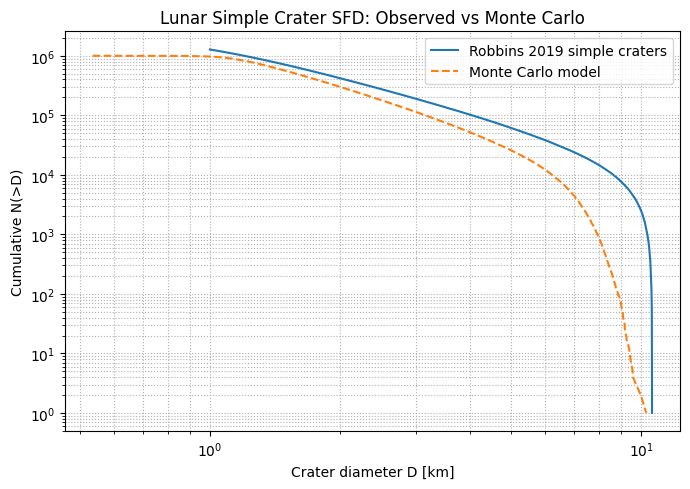

In [3]:
catalog = load_crater_catalog("lunar_crater_database_robbins_2018.csv")
simple_catalog = get_simple_craters(catalog)
results = monte_carlo_crater_population(n_runs=N_MONTE_CARLO,simple_craters=simple_catalog,random_state=42,)
D_obs_m = simple_catalog["D_final_m"].to_numpy()
D_sim_m = results["crater_diameters_m"]
plot_sfd_overlay(D_obs_m, D_sim_m)
# print("First 10 simulated crater diameters [m]:")
# print(D_sim_m[:10])